In [1]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [5]:
df=pd.read_csv(r"C:\Users\aman.khatri91425\Desktop\complete 1.csv")

In [13]:
print(df.head())

df["TIME_DECISION_DATE"] = pd.to_datetime(df["TIME_DECISION_DATE"],dayfirst = True)

   SKP_CREDIT_CASE TIME_DECISION_DATE    CUS_LAT   CUS_LONG  RISK_FPD10  \
0        273217442           15-09-19  26.925771  75.823658           0   
1        273217520           15-09-19  28.704617  77.046645           0   
2        273217523           15-09-19  11.089342  77.336750           0   
3        273217525           15-09-19  19.179927  73.028721           0   
4        273217526           15-09-19  12.917143  80.192349           0   

   RISK_FPD30  RISK_FSPD30  RISK_FSTPD30  RISK_FSTQPD30  RISK_FSTQPD60  \
0           0            0             0              0              0   
1           0            0             0              0              0   
2           0            0             0              0              0   
3           0            0             0              0              0   
4           0            0             0              0              0   

  NTC_FLAG  RISK_SCORE  
0      NTC    0.164707  
1      NTC    0.111792  
2      NTC    0.111993  
3   

In [20]:
df["TIME_DECISION_DATE"].dt.strftime('%Y-%m').value_counts()

19-08    370472
19-07    354387
19-06    303776
19-09    185665
Name: TIME_DECISION_DATE, dtype: int64

In [2]:
#connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
#cursor = connection.cursor()
#os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")
#df=pd.read_pickle(os.getcwd()+"\\Data Files\\sql_data.pkl")
# qu1= """
# select * from TMP_BD_GRID_DISTANCE_ID_NEW
# where risk_agrf120 =1 
# """
#df = pd.read_sql(qu1,connection)
#df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.pkl")
#df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.csv")

In [4]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_new_grids.pkl")

In [5]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,CLIENT_EXI_3M,RISK_SCORE,RNK
0,154206937,2018-01-02,12.913236,77.699678,0,1,CD,N,0.021106,1
1,154432501,2018-01-02,28.725803,77.175379,0,1,CD,N,0.027432,1
2,154536129,2018-01-01,25.313181,82.953024,1,1,CD,N,0.034592,1
3,154536988,2018-01-01,21.320343,72.868642,0,1,CD,N,0.042080,1
4,154545377,2018-01-01,22.690763,75.828938,0,1,CD,N,0.008329,1


In [6]:
df.dropna(subset = ["RISK_SCORE"], inplace = True)

In [7]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")
df_summ = df.groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

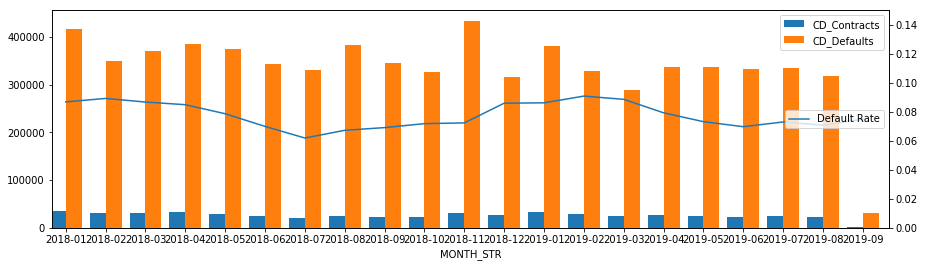

In [8]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [9]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2018, 2, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 1, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 2, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 3, 31))]

In [10]:
df_train.shape

(4340015, 11)

In [11]:
df_test.shape

(617360, 11)

Random under-sampling:
1    224261
0    224261
Name: RISK_FSTQPD30, dtype: int64


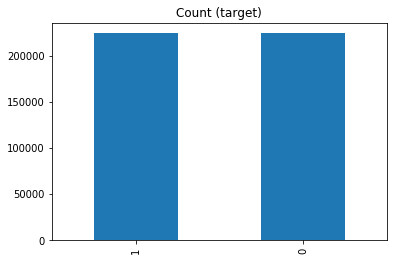

In [10]:
#Downsampling Code 
count_class_0, count_class_1 = df_train.RISK_FSTQPD30.value_counts()
df_class_0 = df_train[df_train['RISK_FSTQPD30'] == 0]
df_class_1 = df_train[df_train['RISK_FSTQPD30'] == 1]
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under.RISK_FSTQPD30.value_counts())

df_train_under.RISK_FSTQPD30.value_counts().plot(kind='bar', title='Count (target)');

In [11]:
X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

y_train = df_train_under["RISK_FSTQPD30"]
y_test =  df_test["RISK_FSTQPD30"]


In [12]:
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))

metric_auc_hcc_train = metrics.roc_auc_score(y_train, X_train['RISK_SCORE'])
gini_hcc_train = 2 * metric_auc_hcc_train - 1

metric_auc_hcc_test = metrics.roc_auc_score(y_test, X_test['RISK_SCORE'])
gini_hcc_test = 2 * metric_auc_hcc_test - 1

print("\nGini in train set :", '{:,.2%}'.format(gini_hcc_train))
print("\nGini in test set :", '{:,.2%}'.format(gini_hcc_test))


Event rate in train set : 50.00%

Event rate in test set : 10.08%

Gini in train set : 29.93%

Gini in test set : 25.02%


In [13]:
param_grid = {'n_neighbors': np.arange(1,1000,10),
              'weights' : ['uniform','distance']
            }
seed = 25

In [14]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier()
kfolds = StratifiedKFold(4, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=40,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [ ]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..


In [116]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Common Maps-KNN_V1_DownSampling_RCV_results.csv")

NameError: name 'dic' is not defined

In [32]:
tmp1= pd.DataFrame(dic)[["param_weights","param_n_neighbors","mean_test_roc_auc","mean_train_roc_auc"]]

In [37]:
tmp1

,param_weights,param_n_neighbors,mean_test_roc_auc,mean_train_roc_auc
0,uniform,741,0.549961,0.573360
1,distance,671,0.528955,0.879760
2,uniform,411,0.550704,0.579561
3,distance,961,0.528997,0.879760
4,distance,501,0.528888,0.879760
5,uniform,631,0.550297,0.574957
6,distance,341,0.528749,0.879754
7,uniform,201,0.549056,0.587388
8,distance,171,0.528249,0.879732
9,distance,551,0.528918,0.879760


In [16]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.5507039945311285
Best params: 
n_neighbors: 411
weights: 'uniform'


In [13]:
#update estimated hyperparameter values to new model
from sklearn.neighbors import KNeighborsClassifier
params = {'n_neighbors': 411}
kfolds = StratifiedKFold(4, random_state=1)
knn = KNeighborsClassifier(**params)
# cross validation gini
auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                         n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()


In [14]:
bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [15]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1


In [16]:
print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))
print("\nGINI CV:",'{:,.2%}'.format(gini_cv))

GINI TRAIN: 15.85%

GINI TEST: 11.72%

GINI CV: 10.25%


In [17]:
df_train_under['PRED_SCORE'] = ypred_train
df_test['PRED_SCORE'] = ypred_test

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
df_combined_score=df_test[['RISK_SCORE','PRED_SCORE','RISK_FSTQPD30','SKP_CREDIT_CASE', 'TIME_DECISION_DATE']]

In [101]:
#Calculate Gini Lift Logistic Regression
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(df_combined_score[['RISK_SCORE','PRED_SCORE']],df_combined_score["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [102]:
y_pred_comb=comb.predict_proba(df_combined_score[['RISK_SCORE','PRED_SCORE']])[:,1]

In [103]:
metric_auc_combined = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

In [104]:
print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

gini_combined: 24.86%

gini_knn: 11.76%

gini_hc: 25.02%


In [105]:
#Calculate Gini Lift Linear Regression
from sklearn.linear_model import LinearRegression
comb=LinearRegression()
comb.fit(df_combined_score[['RISK_SCORE','PRED_SCORE']],df_combined_score["RISK_FSTQPD30"])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [106]:
y_pred_comb=comb.predict(df_combined_score[['RISK_SCORE','PRED_SCORE']])

In [107]:
metric_auc_combined = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

In [108]:
print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

gini_combined: 26.57%

gini_knn: 11.76%

gini_hc: 25.02%


In [19]:
df_combined_score["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["RISK_SCORE"]]
df_combined_score["LOGIT_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_combined_score["PRED_SCORE"]]

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [20]:
#Calculate Gini Lift Logistic Regression (p/1-p) transformation
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(df_combined_score[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']],df_combined_score["RISK_FSTQPD30"])

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [21]:
y_pred_comb=comb.predict_proba(df_combined_score[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']])[:,1]

In [22]:
metric_auc_combined = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_combined_score["RISK_FSTQPD30"], df_combined_score["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

In [23]:
print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

gini_combined: 27.10%

gini_knn: 11.72%

gini_hc: 25.02%


In [28]:
print(comb.coef_)
print(comb.intercept_)

[[0.74964582 0.67726671]]
[1.21629788]


In [30]:
df_combined_score["COMB_SCORE"] = y_pred_comb
df_combined_score.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Combined_Scores.pkl")

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
df_combined_score.head()

,RISK_SCORE,PRED_SCORE,RISK_FSTQPD30,SKP_CREDIT_CASE,TIME_DECISION_DATE,LOGIT_RISK_SCORE,LOGIT_PRED_SCORE,COMB_SCORE
2868826,0.015552,0.321168,1,223563879,2019-02-01,-4.147921,-0.748410,0.083169
2874185,0.015991,0.408759,0,223672260,2019-02-03,-4.119591,-0.369097,0.106985
2874436,0.024406,0.386861,0,223673200,2019-02-03,-3.688201,-0.460525,0.134651
2875137,0.011368,0.613139,1,223676221,2019-02-04,-4.465489,0.460525,0.139513
2875564,0.004911,0.406326,0,223678061,2019-02-02,-5.311423,-0.379174,0.046433


In [32]:
-4.147921*0.74964582+  -0.748410*0.67726671 + 1.21629788

-2.4000469377713207

In [34]:
1/(1+np.exp(2.4000469377713207))

0.08316911732424173

In [41]:
1/(1+np.exp(-(df_combined_score["LOGIT_RISK_SCORE"]*0.74964582+ 
              df_combined_score["LOGIT_PRED_SCORE"]*0.67726671 + 1.21629788)))

2868826    0.083169
2874185    0.106985
2874436    0.134651
2875137    0.139513
2875564    0.046433
2876719    0.042873
2878812    0.169723
2879651    0.123493
2879830    0.122023
2880129    0.033160
2880567    0.068405
2880973    0.139311
2881046    0.273116
2881328    0.125185
2882165    0.051603
2882257    0.263787
2882286    0.125147
2882338    0.143432
2882546    0.094421
2882904    0.099619
2882960    0.101700
2883100    0.059929
2883365    0.087257
2883928    0.155119
2883980    0.166869
2884098    0.144871
2884154    0.110712
2884185    0.064728
2884505    0.061690
2884778    0.055048
             ...   
3269653    0.074635
3269654    0.090046
3269655    0.088513
3269656    0.118378
3269657    0.145535
3269658    0.070802
3269659    0.115173
3269660    0.044393
3269661    0.101985
3269662    0.147721
3269663    0.157383
3269664    0.120276
3269665    0.035291
3269666    0.140441
3269667    0.035194
3269668    0.093453
3269669    0.094683
3269670    0.119385
3269671    0.082423


In [85]:
#Check Stability of Combined Model
seed = 25522
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(df_combined_score[["PRED_SCORE","RISK_SCORE",'LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']],df_combined_score["RISK_FSTQPD30"], test_size=test_size, random_state=seed)


In [96]:
from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(X_train[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']],y_train)
y_pred_comb_train=comb.predict_proba(X_train[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']])[:,1]
y_pred_comb_test=comb.predict_proba(X_test[['LOGIT_RISK_SCORE','LOGIT_PRED_SCORE']])[:,1]


C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [97]:
metric_auc_combined_train = metrics.roc_auc_score(y_train, y_pred_comb_train)
metric_auc_knn_train = metrics.roc_auc_score(y_train, X_train["PRED_SCORE"])
metric_auc_hc_train = metrics.roc_auc_score(y_train, X_train["RISK_SCORE"])

metric_auc_combined_test = metrics.roc_auc_score(y_test, y_pred_comb_test)
metric_auc_knn_test = metrics.roc_auc_score(y_test, X_test["PRED_SCORE"])
metric_auc_hc_test = metrics.roc_auc_score(y_test, X_test["RISK_SCORE"])



gini_combined_train = 2 * metric_auc_combined_train - 1
gini_knn_train = 2 * metric_auc_knn_train - 1
gini_hc_train = 2 * metric_auc_hc_train- 1

gini_combined_test = 2 * metric_auc_combined_test - 1
gini_knn_test = 2 * metric_auc_knn_test - 1
gini_hc_test = 2 * metric_auc_hc_test- 1

print("gini_combined_train:",'{:,.2%}'.format(gini_combined_train))
print("\ngini_knn_train:",'{:,.2%}'.format(gini_knn_train))
print("\ngini_hc_train:",'{:,.2%}'.format(gini_hc_train))

print("\ngini_combined_test:",'{:,.2%}'.format(gini_combined_test))
print("\ngini_knn_test:",'{:,.2%}'.format(gini_knn_test))
print("\ngini_hc_test:",'{:,.2%}'.format(gini_hc_test))


gini_combined_train: 27.34%

gini_knn_train: 11.90%

gini_hc_train: 25.15%

gini_combined_test: 26.82%

gini_knn_test: 11.45%

gini_hc_test: 24.72%


In [123]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Combined_Scores.pkl")

In [124]:
#connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
#cursor = connection.cursor()
#os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")
#qu1= """
# select skp_credit_case, grid_id from TMP_BD_GRID_DISTANCE_ID_1
# where risk_agrf120 =1 
# and time_decision_date between '01-FEB-19'
# and '31-MAR-19'
# """
#df1 = pd.read_sql(qu1,connection)
#df1.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_grid_id.pkl")
#df1.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_grid_id.csv")

df1 = pd.read_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump_grid_id.csv")

In [125]:
df = pd.merge(df, df1, on='SKP_CREDIT_CASE')

In [126]:
grid_score = df.groupby("GRID_ID").mean()['PRED_SCORE'].reset_index()
grid_score.columns = ['GRID_ID','MEAN_PRED_SCORE']
grid_score.head()

,GRID_ID,MEAN_PRED_SCORE
0,500_00336_03130,0.430657
1,500_00343_03387,0.474453
2,500_00353_03201,0.435523
3,500_00357_03379,0.476886
4,500_00363_03386,0.479319


In [127]:
df_final = pd.merge(df, grid_score, on = 'GRID_ID')

In [131]:
#Calculate Gini Lift Logistic Regression (p/1-p) transformation on mean grid score

df_final["LOGIT_RISK_SCORE"] = [np.log(x/(1-x)) for x in df_final["RISK_SCORE"]]
df_final["LOGIT_MEAN_PRED_SCORE"] = [np.log(x/(1-x)) for x in df_final["MEAN_PRED_SCORE"]]

from sklearn.linear_model import LogisticRegression
comb=LogisticRegression()
comb.fit(df_final[['LOGIT_RISK_SCORE','LOGIT_MEAN_PRED_SCORE']],df_final["RISK_FSTQPD30"])

y_pred_comb=comb.predict_proba(df_final[['LOGIT_RISK_SCORE','LOGIT_MEAN_PRED_SCORE']])[:,1]

metric_auc_combined = metrics.roc_auc_score(df_final["RISK_FSTQPD30"], y_pred_comb)
metric_auc_knn = metrics.roc_auc_score(df_final["RISK_FSTQPD30"], df_final["MEAN_PRED_SCORE"])
metric_auc_hc = metrics.roc_auc_score(df_final["RISK_FSTQPD30"], df_final["RISK_SCORE"])


gini_combined = 2 * metric_auc_combined - 1
gini_knn = 2 * metric_auc_knn - 1
gini_hc = 2 * metric_auc_hc - 1

print("gini_combined:",'{:,.2%}'.format(gini_combined))
print("\ngini_knn:",'{:,.2%}'.format(gini_knn))
print("\ngini_hc:",'{:,.2%}'.format(gini_hc))

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


gini_combined: 27.19%

gini_knn: 11.80%

gini_hc: 25.02%


In [134]:
df_final = df_final.drop(columns = 'Unnamed: 0')

In [1]:
df_final.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Combined_Scores_mean_grid.pkl")

NameError: name 'df_final' is not defined

In [33]:
import gmplot
# For improved table display in the notebook
from IPython.display import display

gmap = gmplot.GoogleMapPlotter(28.4431, 77.073, 10)

# Overlay our datapoints onto the map
gmap.heatmap(df[df["PRODUCT_GROUP"]=="CD"]["CUS_LAT"], df[df["PRODUCT_GROUP"]=="CD"]["CUS_LONG"])

# Generate the heatmap into an HTML file
gmap.draw("cd_all.html")


gmap1 = gmplot.GoogleMapPlotter(28.4431, 77.073, 10)

# Overlay our datapoints onto the map
gmap1.heatmap(df[(df["PRODUCT_GROUP"]=="CD") & (df["RISK_FSTQPD30"] == 1)]["CUS_LAT"], df[(df["PRODUCT_GROUP"]=="CD") & (df["RISK_FSTQPD30"] == 1)]["CUS_LONG"])

# Generate the heatmap into an HTML file
gmap1.draw("cd_default.html")